In [32]:
import numpy as np
import cv2
import tensorflow as tf

def concat_images_resize_128(images, labels, n_mix=2):
    batch_size, h, w, c = images.shape
    final_h, final_w = 128, 128
    width_per_img = final_w // n_mix

    mixed_images = []
    mixed_labels = []

    for _ in range(batch_size):
        idxs = np.random.choice(batch_size, n_mix, replace=True)
        imgs_to_concat = []

        for i in idxs:
            # Redimensionner chaque image à (128, width_per_img)
            resized_img = cv2.resize(images[i], (width_per_img, final_h))
            imgs_to_concat.append(resized_img)

        # Concaténation horizontale des n_mix images
        concat_img = np.hstack(imgs_to_concat)

        # Moyenne des labels pour avoir un label multi-label
        mixed_label = np.mean(labels[idxs], axis=0)

        mixed_images.append(concat_img)
        mixed_labels.append(mixed_label)

    return np.array(mixed_images), np.array(mixed_labels)

class MixConcatResizeGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, n_mix=2):
        self.generator = generator
        self.n_mix = n_mix

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        images, labels = self.generator[idx]
        mixed_images, mixed_labels = concat_images_resize_128(images, labels, self.n_mix)
        return mixed_images, mixed_labels


In [ ]:
#Lecture Data

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paramètres
img_size = (128, 128)
batch_size = 32

# Générateurs
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "archive/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    "archive/validation",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    "archive/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Remplace train_gen par ce générateur mixup
train_gen_mixup = MixConcatResizeGenerator(train_gen, n_mix=2)
test_gen_mixup = MixConcatResizeGenerator(test_gen, n_mix=2)
val_gen_mixup = MixConcatResizeGenerator(val_gen, n_mix=2)
print(len(train_gen_mixup) * train_gen.batch_size)

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.
3136


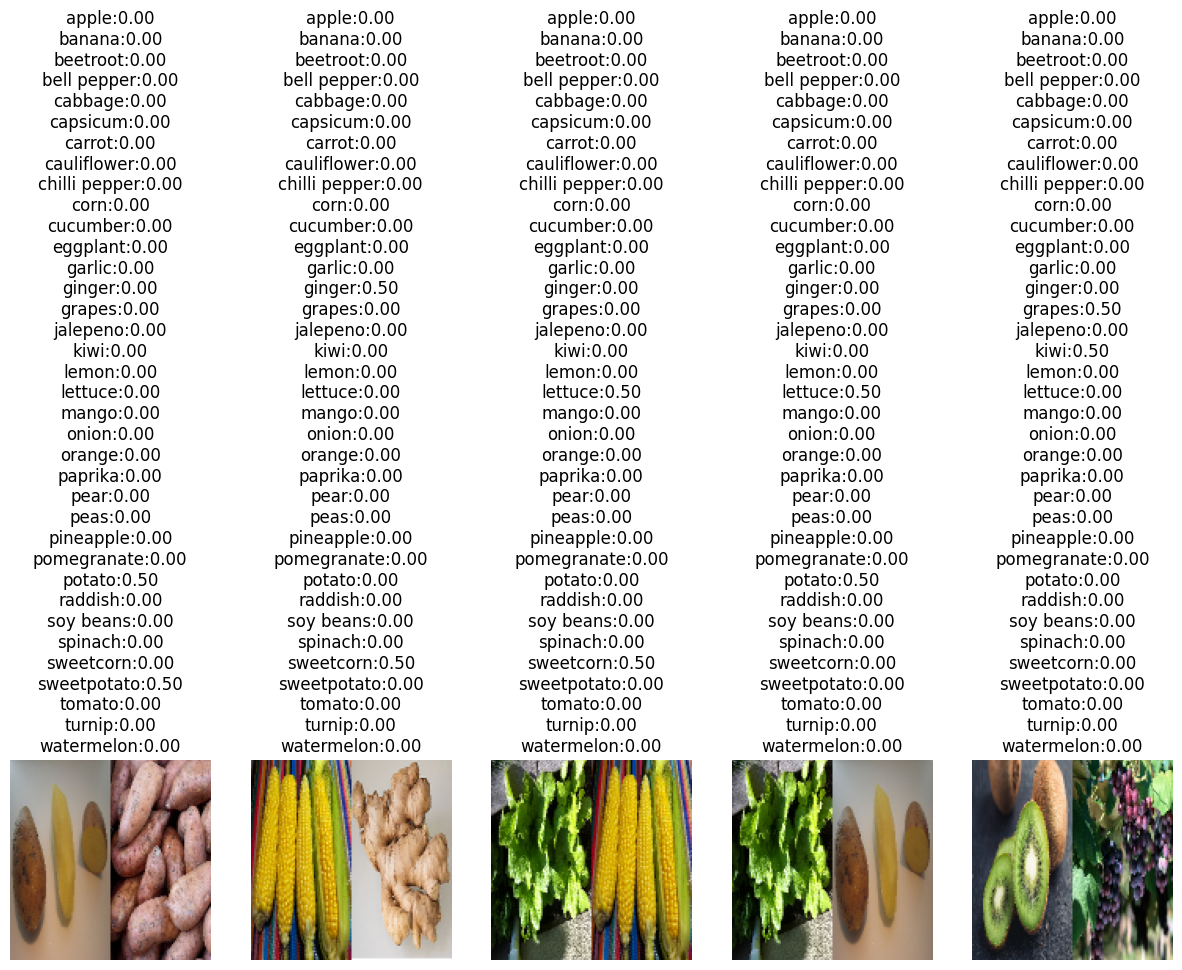

In [34]:
import matplotlib.pyplot as plt

def show_first_images(generator, class_indices):
    images, labels = generator[0]  # Prend le premier batch
    label_names = list(class_indices.keys())
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        # Affiche les pourcentages pour chaque classe
        label_percent = [f"{name}:{labels[i][j]:.2f}" for j, name in enumerate(label_names)]
        plt.title("\n".join(label_percent))
        plt.axis('off')
    plt.show()

# Utilisation :
show_first_images(train_gen_mixup, train_gen.class_indices)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(
    monitor='val_loss',      # Surveille la perte de validation
    patience=3,              # Arrête après 3 epochs sans amélioration
    restore_best_weights=True
)


C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,396,964 (28.22 MB)

 Trainable params: 7,396,964 (28.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen_mixup,
    validation_data=val_gen_mixup,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
10/98 ━━━━━━━━━━━━━━━━━━━━ 4:28 3s/step - accuracy: 0.0557 - loss: 0.5389

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.0383 - loss: 0.2895 - val_accuracy: 0.0598 - val_loss: 0.1315
Epoch 2/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.0378 - loss: 0.1507 - val_accuracy: 0.1225 - val_loss: 0.1227
Epoch 3/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.0453 - loss: 0.1388 - val_accuracy: 0.2108 - val_loss: 0.1185
Epoch 4/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.0721 - loss: 0.1340 - val_accuracy: 0.2678 - val_loss: 0.1138
Epoch 5/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.0782 - loss: 0.1307 - val_accuracy: 0.2792 - val_loss: 0.1101
Epoch 6/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.1122 - loss: 0.1263 - val_accuracy: 0.2963 - val_loss: 0.1108
Epoch 7/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.1274 - loss: 0.1235 - val_accuracy: 0.3162 - val_loss: 0.1055
Epoch 8/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1575 - loss: 0.1203

In [10]:
# Évaluation
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.2%}")

# Prédiction sur de nouvelles images
import numpy as np
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Correspondance index-classe
labels = train_gen.class_indices
labels = dict((v,k) for k,v in labels.items())

# Exemple
for i in range(5):
    print(f"Predicted: {labels[predicted_classes[i]]}, True: {labels[test_gen.classes[i]]}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9383 - loss: 0.3121
Test Accuracy: 96.10%
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 919ms/step
Predicted: apple, True: apple
Predicted: apple, True: apple
Predicted: apple, True: apple
Predicted: apple, True: apple
Predicted: garlic, True: apple
